In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

shap.initjs()

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

explainer = shap.Explainer(model, X_train)

shap_values = explainer(X_test)

In [3]:
shap_values[:,:,0]

.values =
array([[-0.00612071, -0.01792643, -0.01032726, ..., -0.04122048,
        -0.00274726, -0.00100107],
       [-0.00855956, -0.01239552, -0.01237385, ..., -0.04096571,
        -0.00162619, -0.0014231 ],
       [ 0.01340202,  0.0082894 ,  0.01961321, ...,  0.06684571,
         0.00122048,  0.00052952],
       ...,
       [-0.00904369, -0.00730179, -0.01040119, ..., -0.03689643,
        -0.00278083, -0.00021774],
       [-0.00762179, -0.00424226, -0.00909952, ..., -0.03656286,
        -0.00534381, -0.00168274],
       [ 0.0117429 ,  0.01909615,  0.01472262, ...,  0.05932802,
         0.00416766,  0.00351706]])

.base_values =
array([0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044,
       0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044,
       0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044,
       0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044,
       0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044, 0.4044,
      

In [17]:
shap_values

.values =
array([[[-0.00612071,  0.00612071],
        [-0.01792643,  0.01792643],
        [-0.01032726,  0.01032726],
        ...,
        [-0.04122048,  0.04122048],
        [-0.00274726,  0.00274726],
        [-0.00100107,  0.00100107]],

       [[-0.00855956,  0.00855956],
        [-0.01239552,  0.01239552],
        [-0.01237385,  0.01237385],
        ...,
        [-0.04096571,  0.04096571],
        [-0.00162619,  0.00162619],
        [-0.0014231 ,  0.0014231 ]],

       [[ 0.01340202, -0.01340202],
        [ 0.0082894 , -0.0082894 ],
        [ 0.01961321, -0.01961321],
        ...,
        [ 0.06684571, -0.06684571],
        [ 0.00122048, -0.00122048],
        [ 0.00052952, -0.00052952]],

       ...,

       [[-0.00904369,  0.00904369],
        [-0.00730179,  0.00730179],
        [-0.01040119,  0.01040119],
        ...,
        [-0.03689643,  0.03689643],
        [-0.00278083,  0.00278083],
        [-0.00021774,  0.00021774]],

       [[-0.00762179,  0.00762179],
        [-0.00424

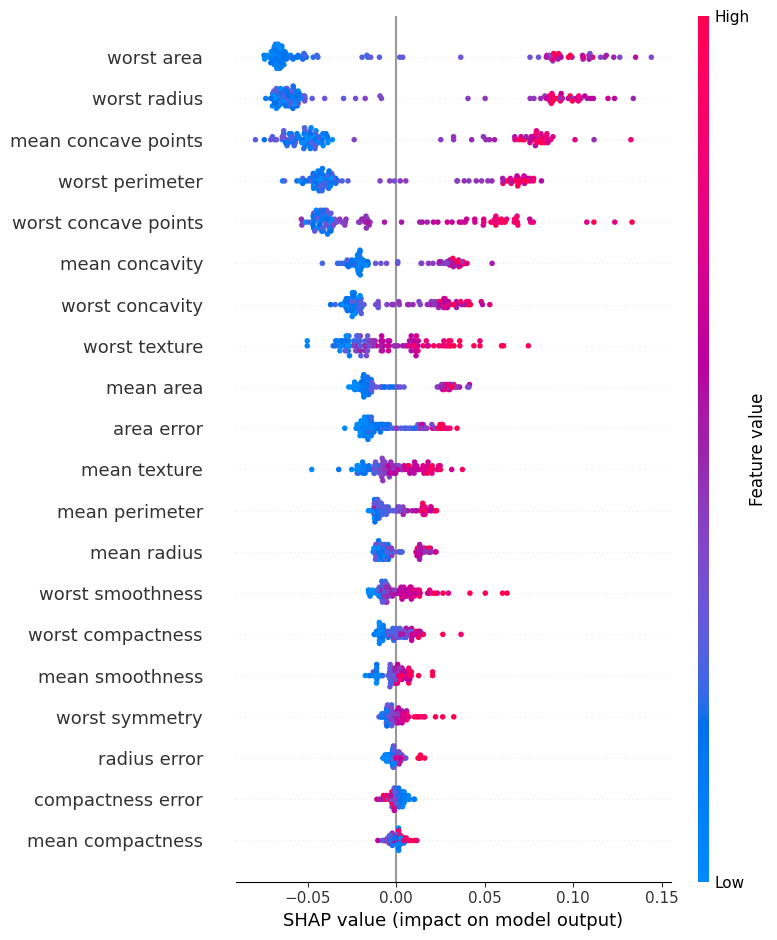

In [4]:
shap.summary_plot(shap_values[:,:,0], X_test) # Talk about this in length

In [17]:
?shap.force_plot

Signature:
shap.force_plot(
    base_value,
    shap_values=None,
    features=None,
    feature_names=None,
    out_names=None,
    link='identity',
    plot_cmap='RdBu',
    matplotlib=False,
    show=True,
    figsize=(20, 3),
    ordering_keys=None,
    ordering_keys_time_format=None,
    text_rotation=0,
    contribution_threshold=0.05,
)
Docstring:
Visualize the given SHAP values with an additive force layout.

Parameters
----------
base_value : float or shap.Explanation
    If a float is passed in, this is the reference value that the feature contributions start from.
    For SHAP values, it should be the value of ``explainer.expected_value``.
    However, it is recommended to pass in a SHAP :class:`.Explanation` object instead (``shap_values``
    is not necessary in this case).

shap_values : numpy.array
    Matrix of SHAP values (# features) or (# samples x # features). If this is a
    1D array, then a single force plot will be drawn. If it is a 2D array, then a
    stacked 

In [5]:
explainer.expected_value

array([0.4044, 0.5956])

In [6]:
shap.force_plot(explainer.expected_value[1], shap_values.values[:1000, :, 1], X_test.iloc[:1000, :])

In [7]:
import mlflow
from tempfile import TemporaryDirectory
from mlflow.models import infer_signature

mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment('breast_cancer')

mlflow.autolog(True, True, silent=True)

# Pull up UI

In [8]:

with mlflow.start_run():
    
    run = mlflow.active_run()
    
    mlflow.sklearn.log_model(model
                            , "model"
                            , input_example=X_train.head(10)
                            , signature=infer_signature(X_test, model.predict(X_test))
                            )
    

In [9]:
# Define a custom pyfunc model
class SHAPModel(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        # Load model and SHAP explainer
        with open(context.artifacts["model"], 'rb') as fin:
            self.model = pickle.load(fin)
    
    def predict(self, context, model_input):
        # Calculate SHAP values
        return self.model.shap_values(model_input)

/Users/troywissenbach/Documents/spring_25_classes/ml_ops/.venv/lib/python3.13/site-packages/mlflow/pyfunc/utils/data_validation.py:134: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [10]:
try:
    mlflow.end_run()
except:
    pass

try:
    mlflow.start_run(run.info.run_id)
except:
    pass

print(run.info.run_id)
print(run.info.run_name)

f3e71afd2ce8481f96eb536d5a027957
worried-pig-524


In [42]:
?mlflow.pyfunc.log_model

Signature:
mlflow.pyfunc.log_model(
    artifact_path,
    loader_module=None,
    data_path=None,
    code_path=None,
    code_paths=None,
    infer_code_paths=False,
    conda_env=None,
    python_model=None,
    artifacts=None,
    registered_model_name=None,
    signature: mlflow.models.signature.ModelSignature = None,
    input_example: Union[pandas.core.frame.DataFrame, numpy.ndarray, dict, list, ForwardRef('csr_matrix'), ForwardRef('csc_matrix'), str, bytes, tuple] = None,
    await_registration_for=300,
    pip_requirements=None,
    extra_pip_requirements=None,
    metadata=None,
    model_config=None,
    example_no_conversion=None,
    streamable=None,
    resources: Union[str, List[mlflow.models.resources.Resource], NoneType] = None,
)
Docstring:
Log a Pyfunc model with custom inference logic and optional data dependencies as an MLflow
artifact for the current run.

For information about the workflows that this method supports, see :ref:`Workflows for
creating custom pyfunc

In [11]:
import pickle

import mlflow.models.signature

with TemporaryDirectory() as temp_dir:
    local_path = temp_dir + '/explainer.pkl'

    with open(local_path, 'wb') as fout:
        pickle.dump(explainer, fout)
        
    artifacts = {
        "model": local_path
    }

    response = mlflow.pyfunc.log_model(
        artifact_path = 'model/explainer'
        , python_model = SHAPModel()
        , artifacts = artifacts
        , input_example = X_test.fillna(0).sample(n=10, random_state=RANDOM_STATE)
        , signature = mlflow.models.signature.infer_signature(model_input=X_test, model_output=explainer.shap_values(X_test))
        , extra_pip_requirements=['shap']
    )

2025/03/29 16:19:26 INFO mlflow.pyfunc: Validating input example against model signature


In [12]:
explainer_check = mlflow.pyfunc.load_model(f'runs:/{run.info.run_id}/model/explainer')
explainer_check.predict(X_test)

array([[[-0.00612071,  0.00612071],
        [-0.01792643,  0.01792643],
        [-0.01032726,  0.01032726],
        ...,
        [-0.04122048,  0.04122048],
        [-0.00274726,  0.00274726],
        [-0.00100107,  0.00100107]],

       [[-0.00855956,  0.00855956],
        [-0.01239552,  0.01239552],
        [-0.01237385,  0.01237385],
        ...,
        [-0.04096571,  0.04096571],
        [-0.00162619,  0.00162619],
        [-0.0014231 ,  0.0014231 ]],

       [[ 0.01340202, -0.01340202],
        [ 0.0082894 , -0.0082894 ],
        [ 0.01961321, -0.01961321],
        ...,
        [ 0.06684571, -0.06684571],
        [ 0.00122048, -0.00122048],
        [ 0.00052952, -0.00052952]],

       ...,

       [[-0.00904369,  0.00904369],
        [-0.00730179,  0.00730179],
        [-0.01040119,  0.01040119],
        ...,
        [-0.03689643,  0.03689643],
        [-0.00278083,  0.00278083],
        [-0.00021774,  0.00021774]],

       [[-0.00762179,  0.00762179],
        [-0.00424226,  0.00

In [13]:
mlflow.end_run()

In [32]:
# Check if there is an active MLflow run
active_run = mlflow.active_run()
if active_run is not None:
    print(f"Active run ID: {active_run.info.run_id}")
    print(f"Active run name: {active_run.info.run_name}")
else:
    print("No active MLflow run")


No active MLflow run
